In [1]:
%%bash --bg
roscore

Starting job # 0 in a separate thread.


In [2]:
%%bash --bg
rosrun stage_ros stageros -g maps/stage/maze.world

Starting job # 2 in a separate thread.


In [3]:
%%bash
rosparam set use_sim_time true

In [4]:
%%bash --bg
rosrun map_server map_server maps/maze.yaml

Starting job # 3 in a separate thread.


In [5]:
!rostopic list

/base_pose_ground_truth
/base_scan
/clock
/cmd_vel
/map
/map_metadata
/odom
/rosout
/rosout_agg
/tf


In [6]:
!rosnode list

/map_server_1519336399596854916
/rosout
/stageros


In [35]:
import rospy
from nav_msgs.msg import MapMetaData, OccupancyGrid, Odometry
from sensor_msgs.msg import LaserScan

def cb_MapMetaData(data):
    global mmd
    mmd = data
    
def cb_OccupancyGrid(data):
    global og
    og = data.data
    
def cb_Pose(data):
    global pose
    pose = data.pose.pose
    
def cb_Scan(data):
    global scan
    scan = data

def pixel(x, y, mmd):
    #x = pose.position.x
    #y = pose.position.y
    xp = x / mmd.resolution
    yp = y / mmd.resolution
    return (xp, mmd.height - yp)

In [8]:
rospy.init_node('listener', anonymous=True)

In [9]:
rospy.Subscriber('/map_metadata', MapMetaData, cb_MapMetaData)
rospy.Subscriber('/map', OccupancyGrid, cb_OccupancyGrid)
rospy.Subscriber('/base_pose_ground_truth', Odometry, cb_Pose)
rospy.Subscriber('/base_scan', LaserScan, cb_Scan)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def plot_stage():
    plt.rcParams["figure.figsize"] = (6,6)
    plt.clf();
    m = np.array(og)
    m = np.flipud(100 - m.reshape((200, 200)))
    plt.imshow(m, cmap='gray');
    plt.axis('off');
    (x, y) = pixel(pose.position.x, pose.position.y, mmd)
    plt.plot(x,y,'o');
    angles = np.arange(len(scan.ranges)) * scan.angle_increment + scan.angle_min
    ranges = np.array(scan.ranges)
    x = np.append([0], scan.ranges * np.cos(angles)) + pose.position.x
    y = np.append([0], scan.ranges * np.sin(angles)) + pose.position.y
    (x, y) = pixel(x, y, mmd)
    plt.fill(x,y,'c.')
    display.display(plt.gcf())
    display.clear_output(wait=True)

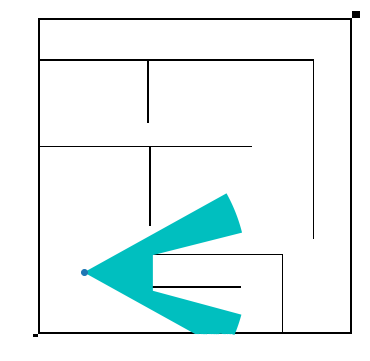

In [48]:
from geometry_msgs.msg import Twist

rate = rospy.Rate(10) # 10hz
pub = rospy.Publisher('cmd_vel', Twist, queue_size=10)
twist = Twist()
twist.linear.x = -0.25
for i in range(50):
    pub.publish(twist)
    plot_stage()
    rate.sleep()